### Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Load Data

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Glucofy-Team/Glucofy-Machine-Learning/main/data/(modified)%20nutrition%20food%20dataset.csv')
data

,category,name,glycemic_index,glycemic_load,calories (kcal),proteins (g),carbohydrates (g),fats (g)
0,Other,Yeast,35.0,6.3,105.0,8.0,18.0,1.9
1,Other,Brewer’s yeast,35.0,0.0,75.0,12.7,0.0,2.7
2,Other,Maltodextrin,95.0,94.0,380.0,0.0,99.0,0.0
3,Other,Palm pulp,20.0,1.2,354.0,3.4,6.2,33.5
4,Other,Omelette,49.0,7.3,210.0,14.0,15.0,2.1
...,...,...,...,...,...,...,...,...
581,Baked products,Pumpernickel Bread,45.0,21.6,250.0,9.0,48.0,3.1
582,Baked products,Rice Bread,70.0,48.0,306.0,6.3,68.6,0.7
583,Baked products,Bran bread,65.0,29.4,227.0,7.0,45.2,1.3
584,Baked products,Pumpkin bread,40.0,17.0,211.0,5.5,42.6,2.4


### Preprocessing Data

In [ ]:
numeric_features = ['glycemic_index', 'calories (kcal)', 'proteins (g)', 'carbohydrates (g)', 'fats (g)']
X = data[numeric_features]
y_gl = data['glycemic_load']

In [ ]:
X_train, X_test, y_gl_train, y_gl_test = train_test_split(X, y_gl, test_size=0.1, random_state=42)

- Standardize the data to ensure the input features are balanced.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Glycemic Index Prediction

In [ ]:
baseline_pred = np.mean(y_gl_train)
baseline_loss = np.mean(np.abs(y_gl_test - baseline_pred))
print(f'Baseline MAE Loss: {baseline_loss}')

Baseline MAE Loss: 15.076435210497541


#### Linear Regression

In [ ]:
regression = LinearRegression()
regression_gi = regression.fit(X_train_scaled, y_gl_train)

In [ ]:
def model_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)

    return MAE, MSE, RMSE, R2_Score

In [ ]:
reg_mae, reg_mse, reg_rmse, reg_r2 = model_evaluation(regression_gi, X_test_scaled, y_gl_test)

In [ ]:
regression_gi_df = pd.DataFrame([[reg_mae, reg_mse, reg_rmse, reg_r2]],
                                index=['Linear Reg.'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

regression_gi_df

,MAE,MSE,RMSE,R2-Score
Linear Reg.,5.335808,68.640775,8.284973,0.854487


#### Decision Tree

In [ ]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train_scaled, y_gl_train)

DecisionTreeRegressor()

In [ ]:
tree_mae, tree_mse, tree_rmse, tree_r2 = model_evaluation(tree_regressor, X_test_scaled, y_gl_test)

tree_gi_df = pd.DataFrame([[tree_mae, tree_mse, tree_rmse, tree_r2]],
                                index=['Decision Tree'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

tree_gi_df

,MAE,MSE,RMSE,R2-Score
Decision Tree,1.469492,10.469322,3.235633,0.977806


#### Support Vector Regression

In [ ]:
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.fit(X_train_scaled, y_gl_train)

SVR()

In [ ]:
svr_mae, svr_mse, svr_rmse, svr_r2 = model_evaluation(tree_regressor, X_test_scaled, y_gl_test)

svr_gi_df = pd.DataFrame([[svr_mae, svr_mse, svr_rmse, svr_r2]],
                                index=['SVR'],
                                columns=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

svr_gi_df

,MAE,MSE,RMSE,R2-Score
SVR,1.469492,10.469322,3.235633,0.977806


#### Neural Network

In [ ]:
def create_nn_model_gl():

    model_gl = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(len(numeric_features),)),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='relu')
    ])

    return model_gl

In [ ]:
def adjust_learning_rate():

    model = create_nn_model_gl()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])

    history = model.fit(X_train_scaled, y_gl_train, epochs=100, callbacks=[lr_schedule], verbose=0)

    return history

In [ ]:
lr_history_gl = adjust_learning_rate()

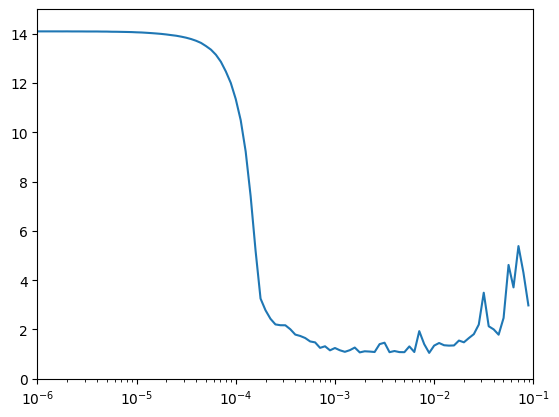

In [ ]:
plt.semilogx(lr_history_gl.history['lr'], lr_history_gl.history['loss'])
plt.axis([1e-6, 1e-1, 0, 15])
plt.show()

In [ ]:
nn_model_gl = create_nn_model_gl()
nn_model_gl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-3), loss=tf.keras.losses.Huber(), metrics=['mae'])

In [ ]:
nn_model_gl.fit(X_train_scaled, y_gl_train, epochs=100, validation_data=(X_test_scaled, y_gl_test), verbose=2)

Epoch 1/100
17/17 - 3s - loss: 12.3320 - mae: 12.7976 - val_loss: 9.1950 - val_mae: 9.6790 - 3s/epoch - 153ms/step
Epoch 2/100
17/17 - 0s - loss: 4.5928 - mae: 5.0457 - val_loss: 2.2059 - val_mae: 2.6232 - 93ms/epoch - 5ms/step
Epoch 3/100
17/17 - 0s - loss: 2.7633 - mae: 3.1995 - val_loss: 2.2087 - val_mae: 2.6497 - 80ms/epoch - 5ms/step
Epoch 4/100
17/17 - 0s - loss: 1.9339 - mae: 2.3539 - val_loss: 1.0970 - val_mae: 1.4726 - 81ms/epoch - 5ms/step
Epoch 5/100
17/17 - 0s - loss: 1.6391 - mae: 2.0208 - val_loss: 1.4291 - val_mae: 1.8437 - 81ms/epoch - 5ms/step
Epoch 6/100
17/17 - 0s - loss: 1.4429 - mae: 1.8268 - val_loss: 1.0212 - val_mae: 1.3682 - 71ms/epoch - 4ms/step
Epoch 7/100
17/17 - 0s - loss: 1.2918 - mae: 1.6515 - val_loss: 0.8962 - val_mae: 1.2353 - 64ms/epoch - 4ms/step
Epoch 8/100
17/17 - 0s - loss: 1.3578 - mae: 1.7044 - val_loss: 0.9050 - val_mae: 1.2591 - 64ms/epoch - 4ms/step
Epoch 9/100
17/17 - 0s - loss: 1.2001 - mae: 1.5516 - val_loss: 1.4313 - val_mae: 1.8144 - 86m

In [ ]:
nn_gl, nn_mae = nn_model_gl.evaluate(X_test_scaled, y_gl_test, verbose=0)
print("Glycemic Load Model MAE:", nn_mae)

Glycemic Load Model MAE: 0.47395607829093933


In [ ]:
y_gl_prediction = nn_model_gl.predict(X_test_scaled)

print('Predicted GL values: ', [f'{val[0]:.2f}' for val in y_gl_prediction[:30]])
print('True GL values:      ', [f'{val:.2f}' for val in y_gl_test[:30]])

2/2 [==============================] - 0s 10ms/step
Predicted GL values:  ['6.12', '76.92', '4.69', '9.11', '0.00', '56.77', '6.75', '9.33', '3.25', '9.10', '33.53', '2.00', '3.77', '15.43', '6.61', '0.00', '0.00', '18.09', '1.19', '41.25', '22.85', '1.54', '91.22', '32.55', '9.58', '6.62', '1.66', '21.23', '14.61', '0.78']
True GL values:       ['6.00', '78.90', '4.80', '9.00', '0.00', '54.80', '7.00', '9.80', '3.60', '9.00', '32.90', '2.30', '4.00', '15.80', '6.90', '0.00', '0.00', '18.20', '1.20', '40.80', '23.40', '1.50', '94.00', '33.20', '9.80', '6.40', '1.90', '21.60', '14.70', '0.80']


### Compare Model

In [ ]:
mae_dict = {
    'Linear Regression': reg_mae,
    'Decision Tree': tree_mae,
    'SVR': svr_mae,
    'Neural Network': nn_mae
}

best_model = min(mae_dict, key=mae_dict.get)

print("Model with lowest MAE:", best_model)
print("MAE: ", mae_dict[best_model])

Model with lowest MAE: Neural Network
MAE:  0.47395607829093933
